# Trabajo Practico #0 - Algoritmo de Maxima Verosimilitud de Kittler

## Grupo de Trabajo:
- Sophia Contreras
- Yoksan Varela
- Mauro Viquez

## Librerias

In [1]:
import warnings
import torch
import requests
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
from PIL import Image
%matplotlib inline

warnings.filterwarnings("ignore")

## Funciones Generales

In [2]:
def import_image(url):
    """Funcion para poder importar imagenes a traves de un URL"""
    imagen_raw = requests.get(url)
    img = Image.open(BytesIO(imagen_raw.content)).convert('L')
    print("Detalles de img: ", img)
    return img

def plot_bar(bins, histogram, axis_x_label, axis_y_label, title):
    """Funcion para hacer el plot histogramas"""
    plt.figure()
    plt.bar(bins[:-1], histogram, color ='maroon', edgecolor='k')
    plt.xlabel(axis_x_label)
    plt.ylabel(axis_y_label)
    plt.title(title)
    plt.show()
    
def gaus_den_func(value,mean,stddev):
    """Funcion de la densidad de probabilidad gaussiana"""
    # Dividiendo la ecuacion por secciones para facilitar la implementacion
    magnitud = 1/(stddev*torch.sqrt(torch.tensor(2*torch.pi)))
    exp_1 = -1/(2*torch.float_power(torch.tensor(stddev),2))
    exp_2 = torch.float_power(torch.tensor(value-mean),2)
    exponencial = torch.exp(exp_1*exp_2)
    
    # Finalmente, se completa la operacion de la funcion de densidad gaussiana
    p_value = magnitud*exponencial
    
    return p_value

## Seccion 1.A: Funcion calcular_momentos_estadisticos

In [42]:
# Funcion toma como parametros T y p
def calcular_momentos_estadisticos(T,p):
    """ 
        Funcion para calcular los momentos estadisticos: P1, P2, mean1, mean2, std1 y std2
        Recibe T que es umbral candidato a ser evaluado, el cual se usara para partir la funcion de densidad en dos.
        p es una funcion de densidad normalizada
    """
    # Creando dos arreglos, divididos por T
    p_1 = p[0:T]
    p_2 = p[T+1:255]
    
    # Calculando las Probabilidades Marginales
    P1 = p_1.sum()
    P2 = p_2.sum()
    
    # Calculando las medias
    mean1 = sum(hz * z for hz,z in enumerate(p_1, start=1))/(P1)
    print(mean1)
    
    return p_2

## Seccion 1.D: Aplique el algoritmo de Kittler en la imagen *cuadro1_005.bmp* provista.
### Parte 1: Grafique el histograma normalizado de la imagen de entrada provista.

Detalles de img:  <PIL.Image.Image image mode=L size=756x455 at 0x1E60F512950>


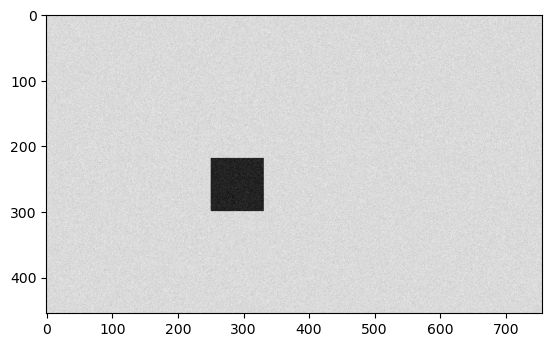

In [4]:
# URL imagen cuadro1_005.bmp
url_imagen = 'https://raw.githubusercontent.com/YoksanVC/TEC_DataScienceCert/main/Module_3_Estadistica_CienciaDatos/Trabajo_Practico_0_Kittler/Documentos_Dropbox/input/cuadro1_005.bmp'

# Creando imagen
imagen = import_image(url_imagen)

# Mostrando imagen
plt.imshow(imagen, cmap = 'gray')
plt.show()


In [5]:
# Creando una matriz con la imagen
vector_imagen = torch.tensor(np.array(imagen))
print(vector_imagen.shape)

torch.Size([455, 756])


tensor([219, 218, 219,  ..., 221, 225, 224], dtype=torch.uint8)


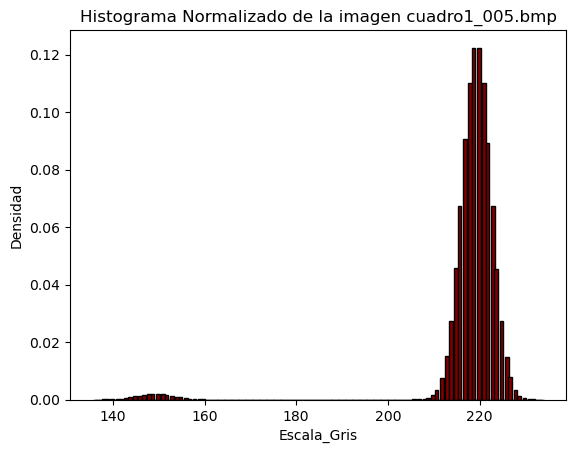

In [12]:
# Creando un array de la matriz con la funcion ravel de Numpy
array_imagen = vector_imagen.ravel()
print(array_imagen)

# Creando un histograma del arreglo anterior y normalizandolo
hist_imagen, bins_imagen = np.histogram(array_imagen, bins = 256)
hist_norm_imagen = hist_imagen/hist_imagen.sum()

# Imprimir el histograma de la imagen
plot_bar(bins_imagen,hist_norm_imagen,"Escala_Gris","Densidad","Histograma Normalizado de la imagen cuadro1_005.bmp")

In [43]:
# Llamando a la funcion calcular_momentos_estadisticos
tmp_hist = calcular_momentos_estadisticos(180,hist_norm_imagen)

35.630239292790726
